In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load local version of gallifrey, before pip installed version, for debugging
import pathlib
import sys
import os

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [3]:
import yt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gallifrey.setup import data_setup
from gallifrey.utilities.math import calculate_pca
from gallifrey.utilities.dataframe import aggregated_dataframe, rename_labels
from gallifrey.visualization.visualization_utils import (
    set_plot_defaults,
    get_palette,
    FigureProcessor,
    ridgeplot,
)

## DATA SETUP

In [4]:
snapshot = 127
resolution = 4096
sim_id = "09_18"

In [5]:
ds, mw, stellar_model, imf, planet_model = data_setup(
    snapshot=snapshot,
    resolution=resolution,
    sim_id=sim_id,
)


      DETECTED LOCAL MACHINE: Test snapshot loaded.

yt : [INFO     ] 2023-09-12 10:45:15,300 Calculating time from 1.000e+00 to be 4.318e+17 seconds
yt : [INFO     ] 2023-09-12 10:45:15,352 Parameters: current_time              = 4.318436660023809e+17 s
yt : [INFO     ] 2023-09-12 10:45:15,353 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-09-12 10:45:15,353 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-09-12 10:45:15,354 Parameters: domain_right_edge         = [100. 100. 100.]
yt : [INFO     ] 2023-09-12 10:45:15,354 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-09-12 10:45:15,354 Parameters: current_redshift          = 4.440892098500626e-16
yt : [INFO     ] 2023-09-12 10:45:15,355 Parameters: omega_lambda              = 0.682
yt : [INFO     ] 2023-09-12 10:45:15,355 Parameters: omega_matter              = 0.318
yt : [INFO     ] 2023-09-12 10:45:15,356 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 202

## PLOT SETUP

In [6]:
set_plot_defaults()
figure_directory = "Galaxy_components"

## CREATE DATA SOURCE

In [7]:
radius = 0.1 * mw.virial_radius()
sphere_data = mw.sphere(radius=radius)

In [8]:
components = ["bulge_stars", "thin_disk_stars", "thick_disk_stars", "halo_stars"]
data = aggregated_dataframe(
    components,
    [
        "[Fe/H]",
        "stellar_age",
        "Masses",
    ],
    data_source=sphere_data,
    type_name="Component",
    custom_units={"stellar_age": "Gyr"},
)

# rename components
data["Component"] = data["Component"].apply(
    lambda type: type.replace("_", " ").replace(" stars", "").title()
    if type.endswith("_stars")
    else type
)

# filtering values
filters = {"[Fe/H]": (-2.5, 1)}
for field_value, ranges in filters.items():
    data = data[data[field_value].between(*ranges)]

# rename labels
data, labels = rename_labels(data)

## FRACTION OF MASS IN COMPONENTS

In [9]:
data.groupby("Component")["Masses"].sum()

Component
Bulge         6.522007e+09
Halo          2.858945e+09
Thick Disk    2.379761e+10
Thin Disk     2.886859e+10
Name: Masses, dtype: float64

In [10]:
data.groupby("Component")["Masses"].sum() / data["Masses"].sum()

Component
Bulge         0.105114
Halo          0.046077
Thick Disk    0.383541
Thin Disk     0.465269
Name: Masses, dtype: float64

## STELLAR AGE IN COMPONENTS

In [11]:
data.groupby("Component")[labels["stellar_age"]].describe().T

Component,Bulge,Halo,Thick Disk,Thin Disk
count,37117.000000,15796.000000,130445.000000,145841.000000
mean,8.660013,8.064630,5.964393,2.861234
std,2.646466,2.334067,3.044538,2.270287
min,0.021125,0.046393,0.020130,0.020130
25%,7.731595,6.132904,3.785896,1.137269
50%,8.928396,7.938578,5.859217,2.414024
75%,10.419608,9.873597,8.016196,3.870247
max,13.462528,13.209291,13.452168,13.457962


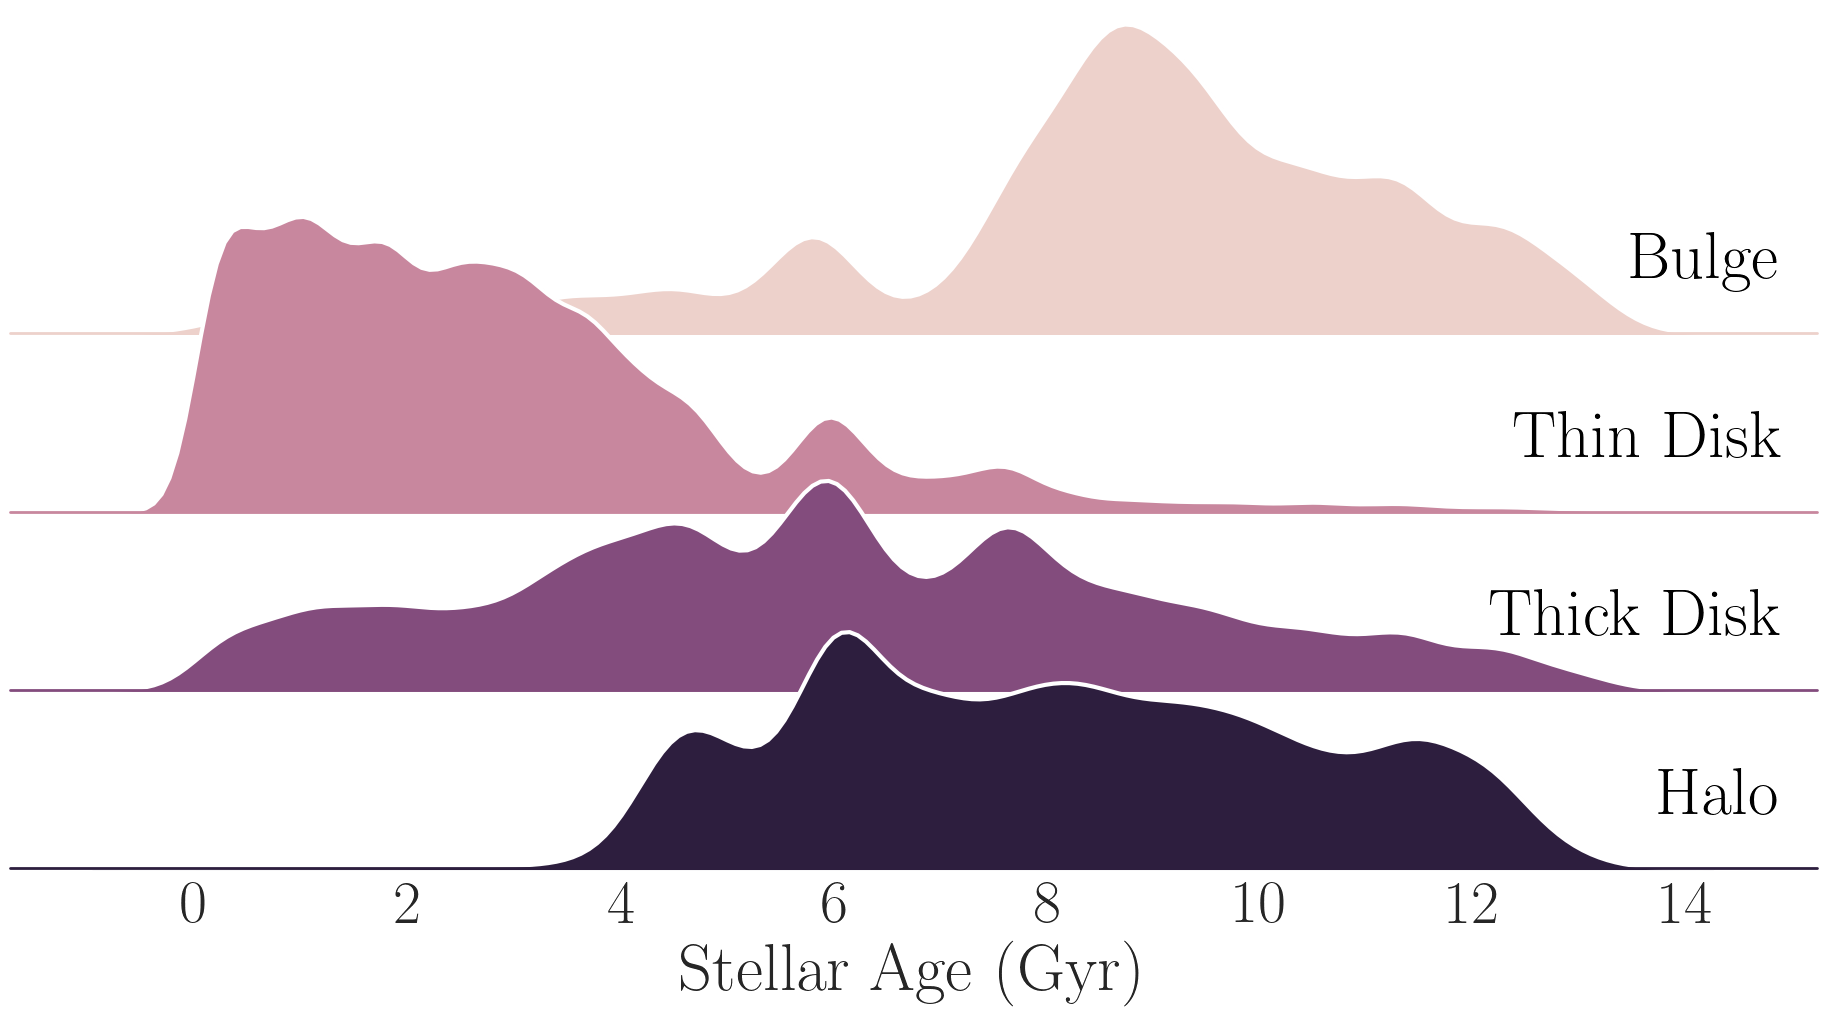

In [12]:
ridgeplot_age = ridgeplot(
    data,
    x=labels["stellar_age"],
    row="Component",
    palette=get_palette(n_colors=4),
    label_position=[0.98, 0.22],
)
FigureProcessor(ridgeplot_age.figure).save(
    "ridgeplot_age.pdf", sub_directory=figure_directory
)

## METALLICITY IN COMPONENTS

In [13]:
data.groupby("Component")["[Fe/H]"].describe().T

Component,Bulge,Halo,Thick Disk,Thin Disk
count,37117.000000,15796.000000,130445.000000,145841.000000
mean,-0.239118,-0.511400,-0.137749,0.029994
std,0.424082,0.467912,0.418804,0.279671
min,-2.495653,-2.497246,-2.493953,-2.475818
25%,-0.523015,-0.738385,-0.390517,-0.154355
50%,-0.207975,-0.460663,-0.131131,0.040846
75%,0.069257,-0.190558,0.181893,0.237340
max,0.716523,0.840895,0.719918,0.718245


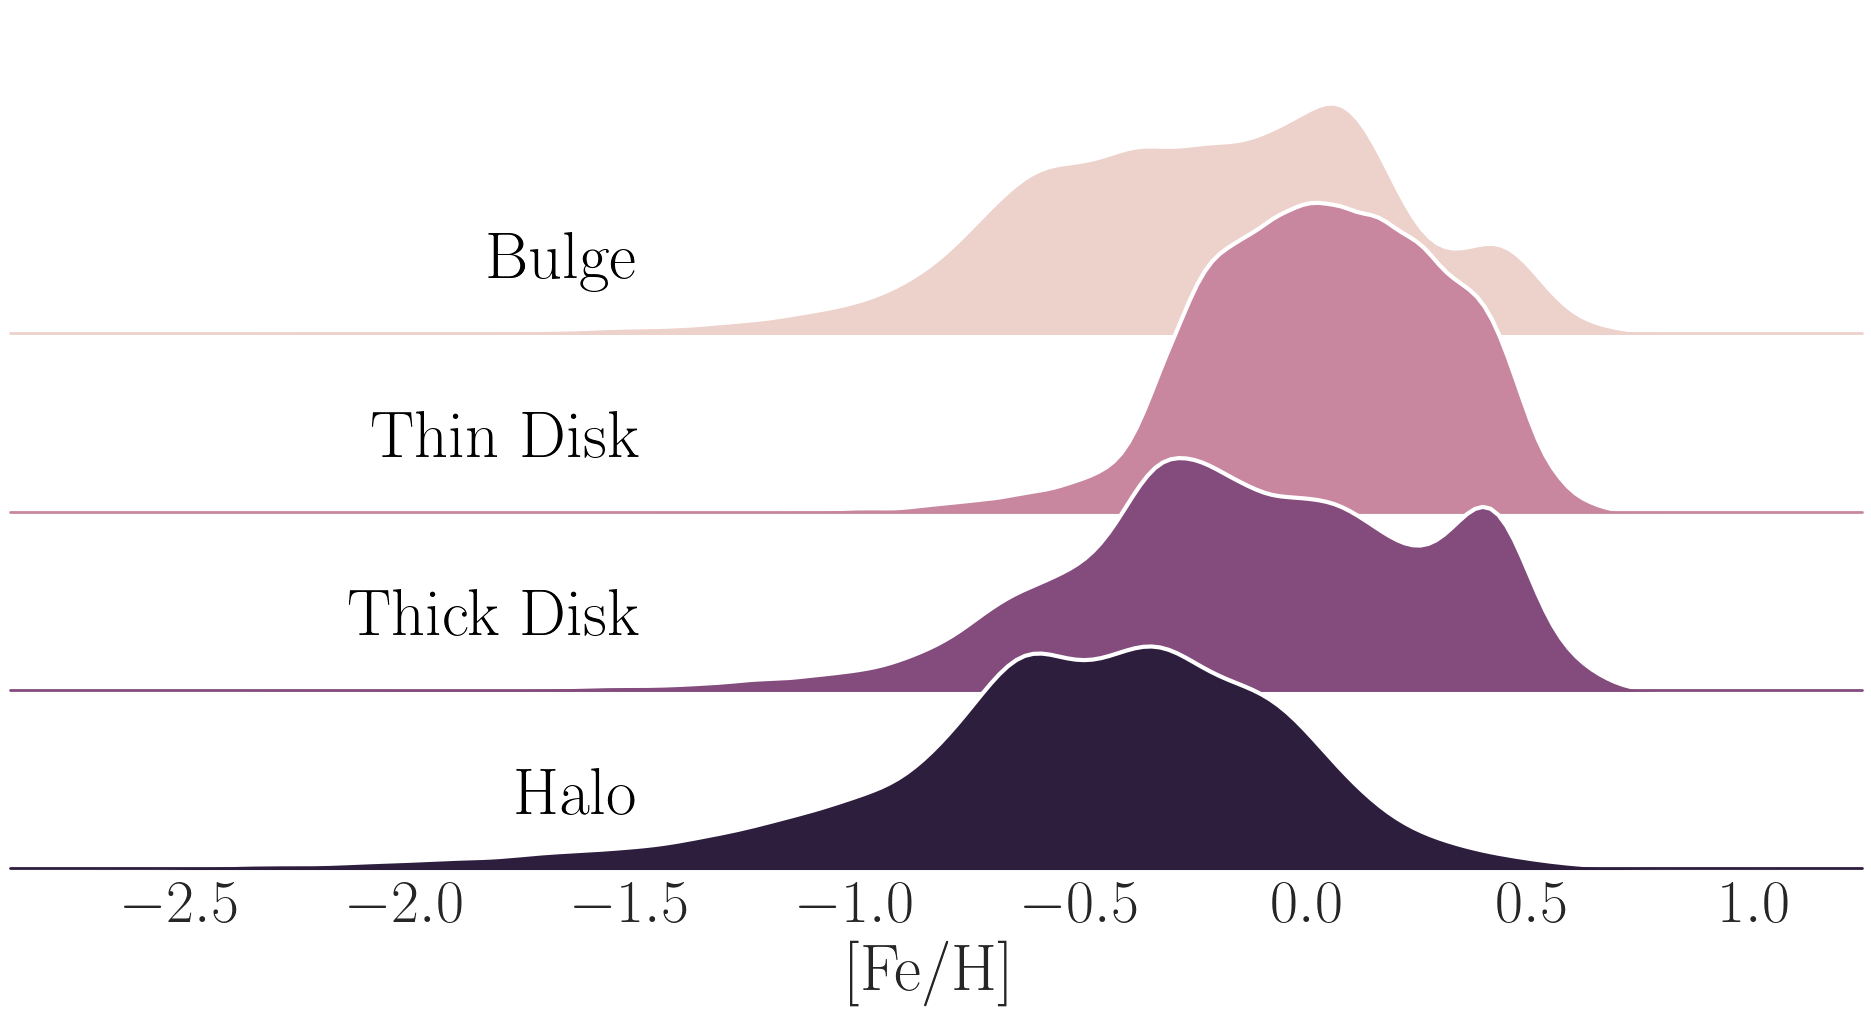

In [14]:
ridgeplot_metallicity = ridgeplot(
    data,
    x=labels["[Fe/H]"],
    row="Component",
    palette=get_palette(n_colors=4),
    label_position=[0.34, 0.22],
)
FigureProcessor(ridgeplot_metallicity.figure).save(
    "ridgeplot_metallicity.pdf", sub_directory=figure_directory
)

In [15]:
from matplotlib.colors import LogNorm

histogram2d_metallicity = sns.histplot(
    data,
    x=labels["[Fe/H]"],
    y=labels["[alpha/Fe]"],
    cbar=True,
    cmap=get_palette(as_cmap=True),
    norm=LogNorm(),
    vmin=None,
    vmax=None,
)
FigureProcessor(histogram2d_metallicity.figure).save(
    "histogram2d_metallicity.pdf", sub_directory=figure_directory
)

KeyError: '[alpha/Fe]'

## PRICIPAL COMPONENTS

In [ ]:
variance_ratios = pd.DataFrame(
    np.array(
        [
            calculate_pca(
                sphere_data[component, "particle_position"].to("kpc")
            ).explained_variance_ratio_
            for component in components
        ]
    ).T,
    columns=components,
).T
variance_ratios